# PROVA — Regressão Logística (Estilo 1ESPA, raiz)
Notebook mínimo, direto ao ponto, com as etapas exatamente como solicitado.

In [1]:
# ============================================
# Imports e configuração básica
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc)
from sklearn.calibration import calibration_curve

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Parte A — 1) Preparação e Análise Exploratória
- Carrega dataset, cria `alvo` (female=1, male=0)
- Verifica proporção das classes (balanceamento)

Total de amostras: 3168
Total de features numéricas: 20

[1.1] Proporção das classes (0=male, 1=female):
alvo
0    0.5
1    0.5
Name: proportion, dtype: float64


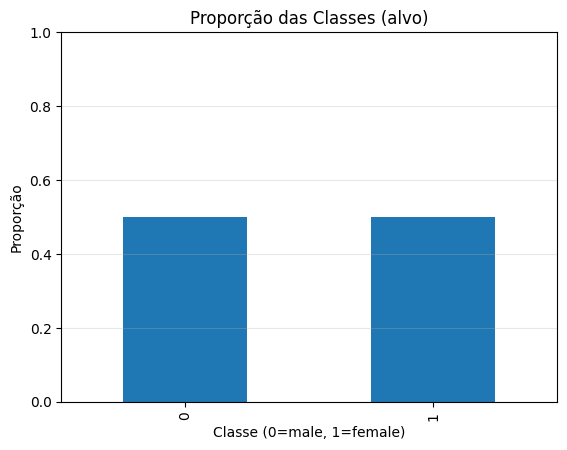

In [2]:
# ============================================
# [1] Carregando dataset e criando alvo (female=1, male=0)
# ============================================
URL = "https://raw.githubusercontent.com/primaryobjects/voice-gender/master/voice.csv"
df = pd.read_csv(URL)

if 'label' not in df.columns:
    raise ValueError("Coluna 'label' não encontrada no CSV.")

df['alvo'] = (df['label'].astype(str).str.lower() == 'female').astype(int)

colunas_numericas = [c for c in df.columns if c not in ('label','alvo') and pd.api.types.is_numeric_dtype(df[c])]
X = df[colunas_numericas].copy()
y = df['alvo'].copy()

print(f"Total de amostras: {len(df)}")
print(f"Total de features numéricas: {len(colunas_numericas)}")

print("\n[1.1] Proporção das classes (0=male, 1=female):")
proporcoes = y.value_counts(normalize=True).sort_index()
print(proporcoes)

# Gráfico simples do balanceamento (escala 0–1)
fig = plt.figure()
proporcoes.plot(kind='bar')
plt.title("Proporção das Classes (alvo)")
plt.xlabel("Classe (0=male, 1=female)")
plt.ylabel("Proporção")
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.show()

### 1.2) Distribuição de cada feature (subplots em UMA imagem, padronizado em Z-score)
- Todas as features com mesma escala (bins e limites iguais).

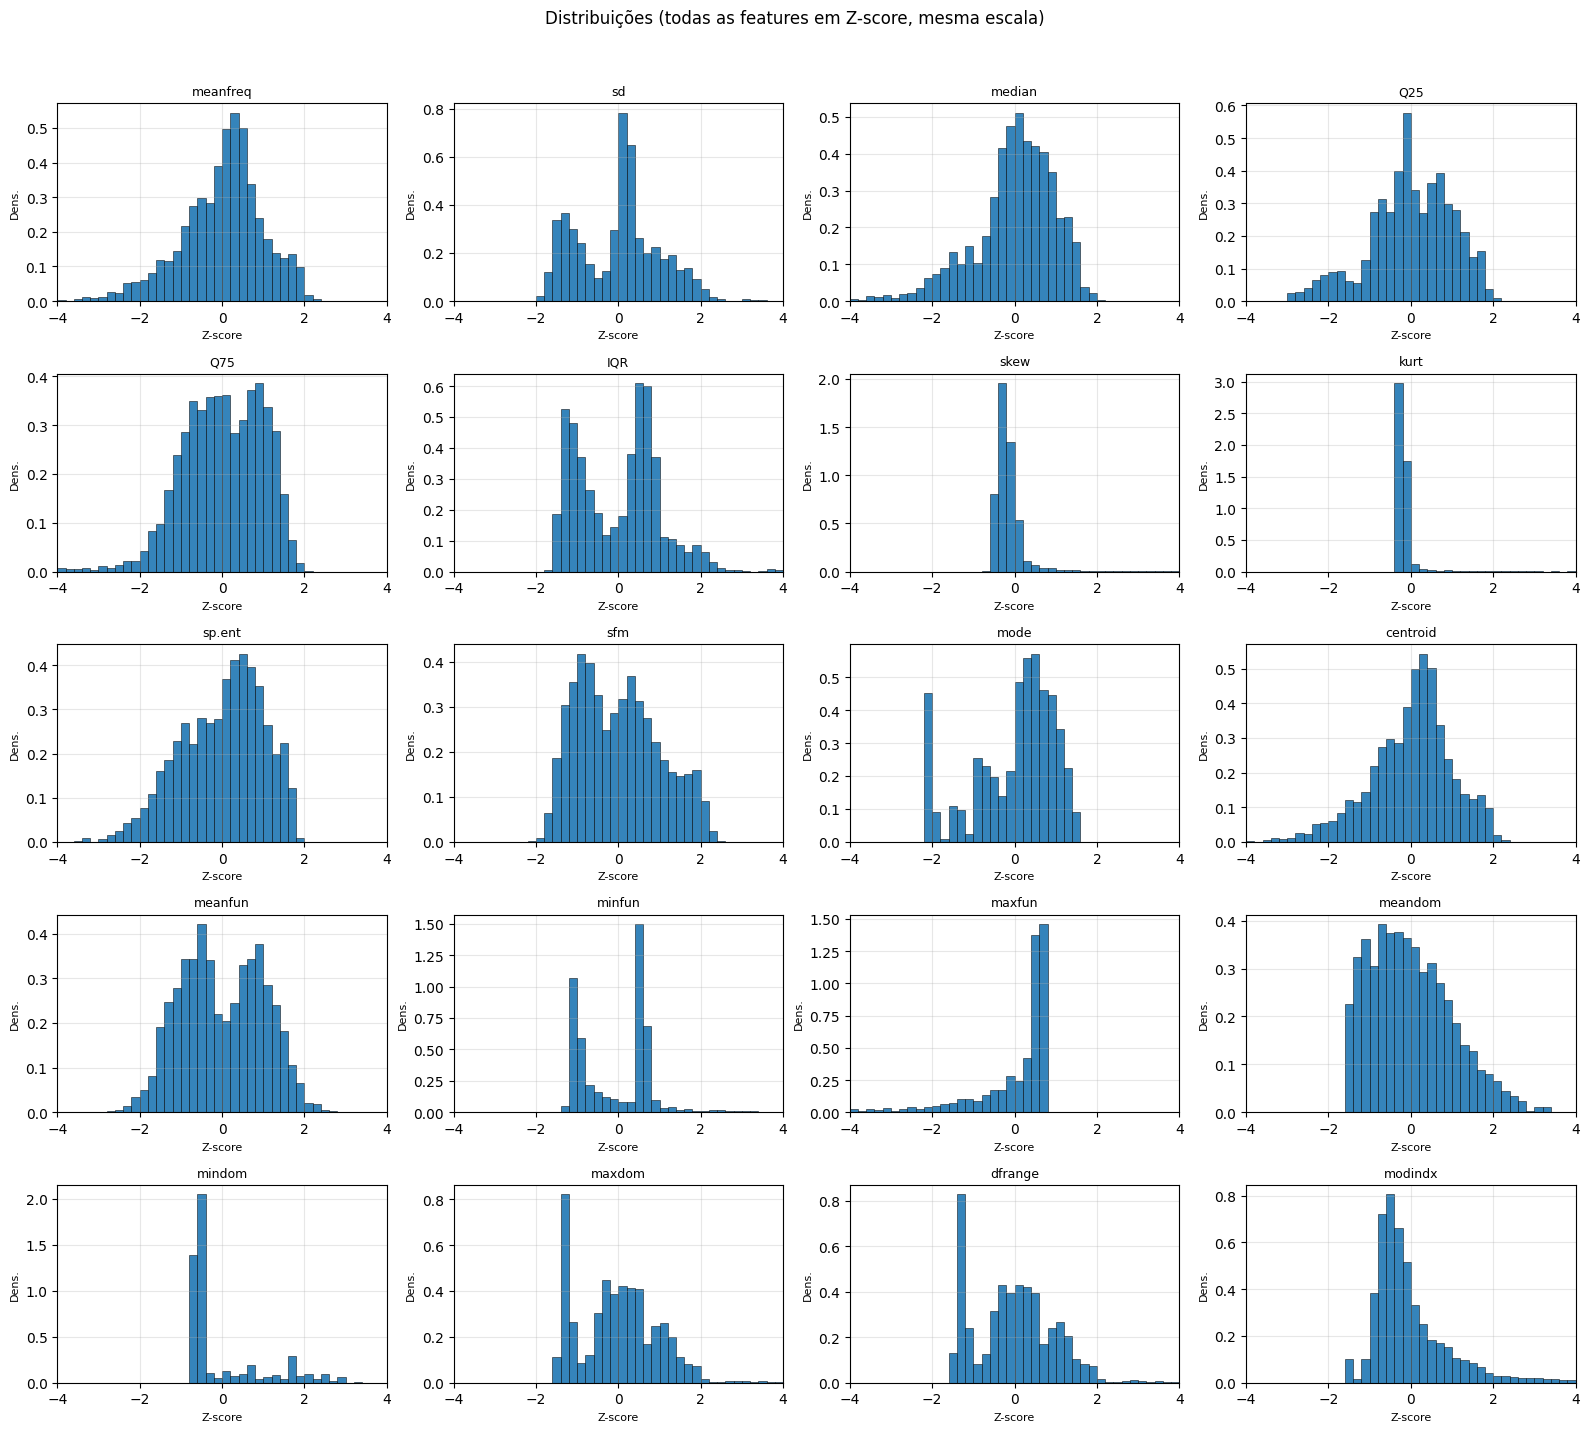

In [3]:
# ============================================
# [1.2] Distribuições em Z-score (subplots em uma única figura)
# ============================================
X_z = X.copy()
desvios_zero = []
for c in colunas_numericas:
    mu = X[c].mean()
    sd = X[c].std(ddof=0)
    if sd == 0 or np.isnan(sd):
        desvios_zero.append(c)
        continue
    X_z[c] = (X[c] - mu) / sd

colunas_plot = [c for c in colunas_numericas if c not in desvios_zero]

# Parâmetros comuns: mesmos bins e limites
bins = np.linspace(-4, 4, 41)
xlim = (-4, 4)

n = len(colunas_plot)
ncols = 4
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 2.8*nrows))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(colunas_plot):
    ax = axes[i]
    vals = X_z[col].dropna()
    ax.hist(vals, bins=bins, density=True, alpha=0.9, edgecolor='black', linewidth=0.4)
    ax.set_title(col, fontsize=9)
    ax.set_xlim(*xlim)
    ax.set_xlabel("Z-score", fontsize=8)
    ax.set_ylabel("Dens.", fontsize=8)
    ax.grid(alpha=0.3)

# Apaga eixos extras (se houver)
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Distribuições (todas as features em Z-score, mesma escala)", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

if desvios_zero:
    print("Aviso: features sem variância (não plotadas):", desvios_zero)

### 1.3) Escalas diferentes e justificativa da padronização
- Resumo simples de amplitude e desvio-padrão (prova da necessidade de padronizar).

In [4]:
# ============================================
# [1.3] Resumo de escalas
# ============================================
resumo = pd.DataFrame({
    'min': X.min(),
    'max': X.max(),
    'amplitude': X.max() - X.min(),
    'std': X.std(ddof=0)
}).sort_values('amplitude', ascending=False)

print(resumo.head(8))
print("Observação: amplitudes e desvios muito distintos entre features justificam padronização (StandardScaler).")

              min          max    amplitude         std
kurt     2.068455  1309.612887  1307.544432  134.907364
skew     0.141735    34.725453    34.583718    4.239859
maxdom   0.007812    21.867188    21.859375    3.520601
dfrange  0.000000    21.843750    21.843750    3.519484
meandom  0.007812     2.957682     2.949870    0.525122
modindx  0.000000     0.932374     0.932374    0.119436
sfm      0.036876     0.842936     0.806059    0.177493
mindom   0.004883     0.458984     0.454102    0.063289
Observação: amplitudes e desvios muito distintos entre features justificam padronização (StandardScaler).


### 1.4) Matriz de correlação e multicolinearidade
- Heatmap manual (matplotlib) e listagem de pares com |r| ≥ 0,85.

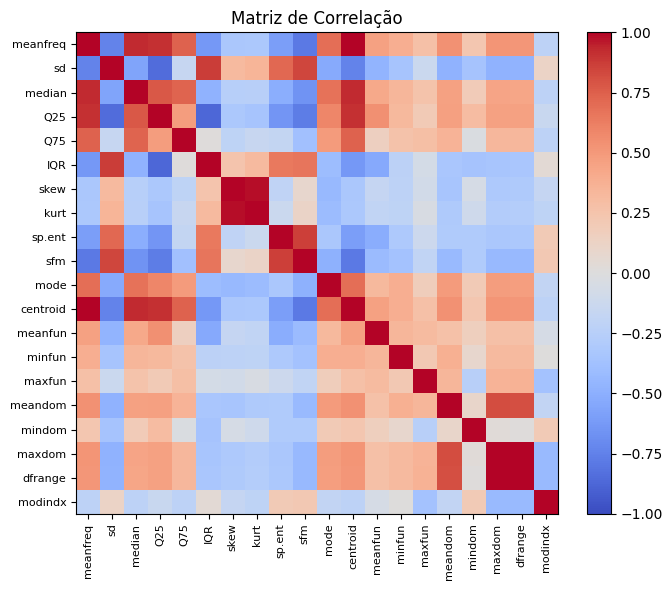

Pares com possível multicolinearidade (|r| >= 0.85):
  meanfreq x centroid: r = 1.000
  maxdom x dfrange: r = 1.000
  skew x kurt: r = 0.977
  meanfreq x median: r = 0.925
  median x centroid: r = 0.925
  meanfreq x Q25: r = 0.911
  Q25 x centroid: r = 0.911
  sd x IQR: r = 0.875
  Q25 x IQR: r = -0.874
  sp.ent x sfm: r = 0.866


In [5]:
# ============================================
# [1.4] Matriz de correlação e alerta de pares com |r| alto
# ============================================
corr = X.corr(numeric_only=True).fillna(0)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Matriz de Correlação")
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90, fontsize=8)
plt.yticks(ticks, corr.columns, fontsize=8)
plt.tight_layout()
plt.show()

limite = 0.85
pares_altos = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if abs(val) >= limite:
            pares_altos.append((cols[i], cols[j], float(val)))

if pares_altos:
    print(f"Pares com possível multicolinearidade (|r| >= {limite}):")
    for a, b, r in sorted(pares_altos, key=lambda t: -abs(t[2])):
        print(f"  {a} x {b}: r = {r:.3f}")
else:
    print(f"Sem pares com |r| >= {limite}.")

## Parte A — 2) Grid Search com Validação Cruzada (k=5)
- `StandardScaler` + `LogisticRegression` (solver liblinear)
- Penalizações L1 e L2; C em [0.01, 0.1, 1, 10, 100]
- Reporta melhor combinação e acurácia média de validação

In [6]:
# ============================================
# [2] Split + GridSearchCV (CV=5) L1/L2 e C
# ============================================
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Formas:", X_treino.shape, X_teste.shape)

pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="liblinear", max_iter=1000, random_state=RANDOM_STATE))
])

param_grid = {
    "logreg__penalty": ["l1", "l2"],
    "logreg__C": [0.01, 0.1, 1, 10, 100],
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    return_train_score=False
)
grid.fit(X_treino, y_treino)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Acurácia média de validação (CV=5): {:.4f}".format(grid.best_score_))

Formas: (2534, 20) (634, 20)
Melhores hiperparâmetros: {'logreg__C': 10, 'logreg__penalty': 'l2'}
Acurácia média de validação (CV=5): 0.9767


## Parte A — 3) Modelo Final e Métricas no Teste
- Reajuste com melhores hiperparâmetros
- Reporte acurácia, precisão, recall, F1-score e matriz de confusão

Desempenho no teste:
  Acurácia : 0.9621
  Precisão : 0.9651
  Recall   : 0.9590
  F1-score : 0.9620


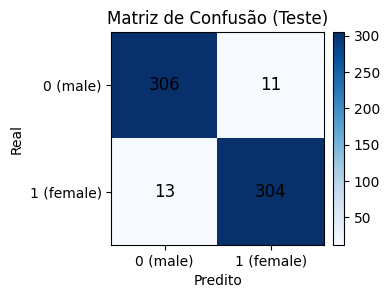

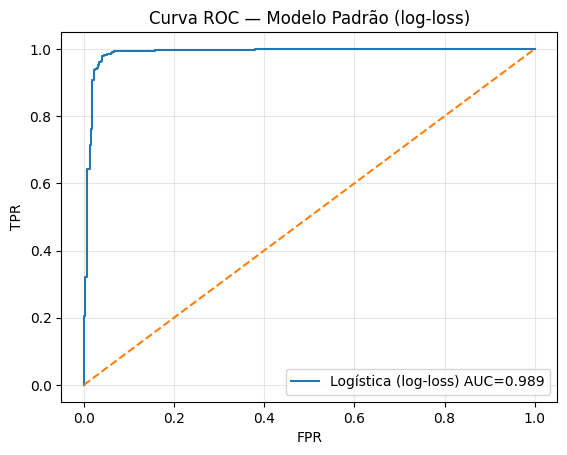

In [7]:
# ============================================
# [3] Modelo final e avaliação no teste
# ============================================
melhor_modelo = grid.best_estimator_
melhor_modelo.fit(X_treino, y_treino)

y_pred = melhor_modelo.predict(X_teste)
y_prob = melhor_modelo.predict_proba(X_teste)[:, 1]

acc  = accuracy_score(y_teste, y_pred)
prec = precision_score(y_teste, y_pred, zero_division=0)
rec  = recall_score(y_teste, y_pred, zero_division=0)
f1   = f1_score(y_teste, y_pred, zero_division=0)

print("Desempenho no teste:")
print(f"  Acurácia : {acc:.4f}")
print(f"  Precisão : {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  F1-score : {f1:.4f}")

cm = confusion_matrix(y_teste, y_pred)
plt.figure(figsize=(4, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Matriz de Confusão (Teste)")
plt.colorbar(fraction=0.046, pad=0.04)
tick_labels = ["0 (male)", "1 (female)"]
plt.xticks([0,1], tick_labels)
plt.yticks([0,1], tick_labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=12)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# Curva ROC (modelo padrão)
fpr, tpr, _ = roc_curve(y_teste, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"Logística (log-loss) AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC — Modelo Padrão (log-loss)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Parte A — 4) Discussão: L1 vs L2, variáveis eliminadas e efeitos práticos
- Compara coeficientes obtidos para L1 e L2
- Lista features eliminadas com L1 (coeficiente zero)
- Comentários objetivos sobre desempenho e interpretabilidade

In [8]:
# ============================================
# [4] L1 vs L2: comparação de coeficientes e variáveis zeradas
# ============================================
cv_df = pd.DataFrame(grid.cv_results_)

def melhor_params_por_penalty(pen):
    sub = cv_df[cv_df['param_logreg__penalty'] == pen]
    sub = sub.sort_values(['mean_test_score', 'param_logreg__C'], ascending=[False, True])
    row = sub.iloc[0]
    return {'penalty': pen, 'C': row['param_logreg__C']}

best_l1 = melhor_params_por_penalty('l1')
best_l2 = melhor_params_por_penalty('l2')
print("Melhores por penalidade:")
print("  L1:", best_l1)
print("  L2:", best_l2)

def fit_and_get_coefs(penalty, C):
    pipe_coef = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(solver="liblinear", max_iter=1000, penalty=penalty, C=C, random_state=RANDOM_STATE))
    ])
    pipe_coef.fit(X_treino, y_treino)
    return pipe_coef.named_steps['logreg'].coef_.ravel()

coefs_l1 = fit_and_get_coefs('l1', best_l1['C'])
coefs_l2 = fit_and_get_coefs('l2', best_l2['C'])

coef_table = pd.DataFrame({'feature': colunas_numericas, 'coef_L1': coefs_l1, 'coef_L2': coefs_l2})
zeradas = coef_table[np.isclose(coef_table['coef_L1'], 0.0, atol=1e-8)]['feature'].tolist()

print("\nTop 10 |coef| L1:")
print(coef_table.reindex(coef_table['coef_L1'].abs().sort_values(ascending=False).index).head(10))

print("\nFeatures eliminadas (coeficiente = 0) pelo L1:")
print(zeradas if zeradas else "Nenhuma")

print("\nEfeitos práticos (resumo objetivo):")
print("- L1 (Lasso) tende a zerar coeficientes, selecionando variáveis e aumentando interpretabilidade.")
print("- L2 (Ridge) encolhe coeficientes sem zerá-los, útil quando há multicolinearidade.")
print("- Em desempenho, diferenças costumam ser pequenas; escolha depende de parcimônia vs. estabilidade.")

Melhores por penalidade:
  L1: {'penalty': 'l1', 'C': np.float64(100.0)}
  L2: {'penalty': 'l2', 'C': np.float64(10.0)}

Top 10 |coef| L1:
     feature   coef_L1   coef_L2
12   meanfun  5.768699  5.682555
9        sfm  2.172342  2.073705
8     sp.ent -1.941268 -1.832246
3        Q25  1.850015  1.589438
5        IQR -1.684043 -1.765976
11  centroid -1.554594 -1.181830
0   meanfreq -1.232693 -1.181830
2     median  0.989893  0.860589
13    minfun -0.713602 -0.696978
1         sd -0.673448 -0.550627

Features eliminadas (coeficiente = 0) pelo L1:
Nenhuma

Efeitos práticos (resumo objetivo):
- L1 (Lasso) tende a zerar coeficientes, selecionando variáveis e aumentando interpretabilidade.
- L2 (Ridge) encolhe coeficientes sem zerá-los, útil quando há multicolinearidade.
- Em desempenho, diferenças costumam ser pequenas; escolha depende de parcimônia vs. estabilidade.


## Parte B — 1) Experimento: Logística com RMSE (treino por gradiente)
- Implementação mínima para treinar probabilidade sigmoide minimizando MSE
- Reporta métricas no teste

In [9]:
# ============================================
# [B1] Logística treinada com RMSE
# ============================================
scaler_rmse = StandardScaler().fit(X_treino)
Xtr_std = scaler_rmse.transform(X_treino)
Xte_std = scaler_rmse.transform(X_teste)

def add_intercept(M):
    return np.hstack([np.ones((M.shape[0], 1)), M])

Xtr_b = add_intercept(Xtr_std)
Xte_b = add_intercept(Xte_std)
ytr = y_treino.values.reshape(-1, 1)
yte = y_teste.values.reshape(-1, 1)

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def train_logistic_rmse(Xb, y, lr=0.1, iters=3000):
    w = np.zeros((Xb.shape[1], 1))
    N = Xb.shape[0]
    for t in range(iters):
        z = Xb @ w
        p = sigmoid(z)
        diff = (p - y)
        grad = (2.0 / N) * (Xb.T @ (diff * p * (1.0 - p)))
        w -= lr * grad
    return w

w_rmse = train_logistic_rmse(Xtr_b, ytr, lr=0.1, iters=3000)

p_rmse_test = sigmoid(Xte_b @ w_rmse).ravel()
y_pred_rmse = (p_rmse_test >= 0.5).astype(int)

acc_rmse  = accuracy_score(y_teste, y_pred_rmse)
prec_rmse = precision_score(y_teste, y_pred_rmse, zero_division=0)
rec_rmse  = recall_score(y_teste, y_pred_rmse, zero_division=0)
f1_rmse   = f1_score(y_teste, y_pred_rmse, zero_division=0)

print("Desempenho (RMSE) no teste:")
print(f"  Acurácia : {acc_rmse:.4f}")
print(f"  Precisão : {prec_rmse:.4f}")
print(f"  Recall   : {rec_rmse:.4f}")
print(f"  F1-score : {f1_rmse:.4f}")

Desempenho (RMSE) no teste:
  Acurácia : 0.9685
  Precisão : 0.9655
  Recall   : 0.9716
  F1-score : 0.9686


## Parte B — 2) Comparação: Log-loss vs RMSE
- Curva ROC dos dois modelos
- Curva de decisão (calibração simples) para checar se as probabilidades estão calibradas

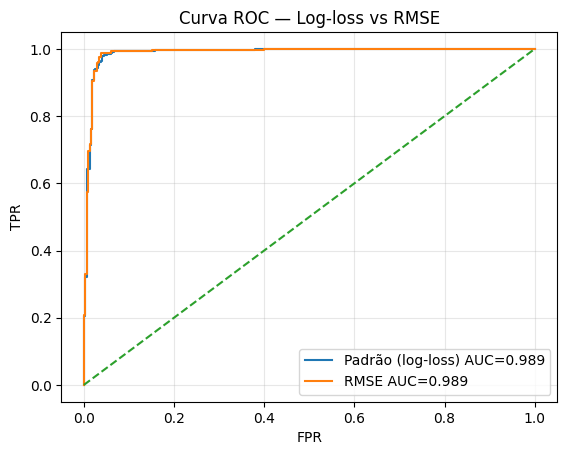

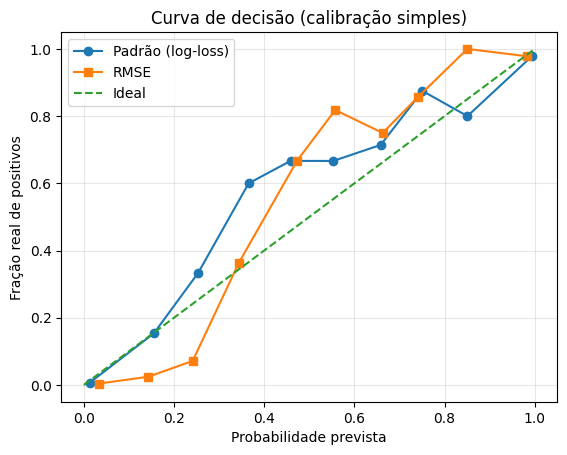

In [10]:
# ============================================
# [B2] ROC e calibração (curva de decisão)
# ============================================
# ROC do modelo padrão já foi calculada (fpr, tpr, roc_auc) com y_prob
fpr_rmse, tpr_rmse, _ = roc_curve(y_teste, p_rmse_test)
auc_rmse = auc(fpr_rmse, tpr_rmse)

plt.figure()
plt.plot(fpr, tpr, label=f"Padrão (log-loss) AUC={roc_auc:.3f}")
plt.plot(fpr_rmse, tpr_rmse, label=f"RMSE AUC={auc_rmse:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC — Log-loss vs RMSE")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Curva de decisão (calibração)
prob_true_log, prob_pred_log = calibration_curve(y_teste, y_prob, n_bins=10, strategy='uniform')
prob_true_rmse, prob_pred_rmse = calibration_curve(y_teste, p_rmse_test, n_bins=10, strategy='uniform')

plt.figure()
plt.plot(prob_pred_log, prob_true_log, marker='o', label="Padrão (log-loss)")
plt.plot(prob_pred_rmse, prob_true_rmse, marker='s', label="RMSE")
plt.plot([0,1], [0,1], linestyle="--", label="Ideal")
plt.xlabel("Probabilidade prevista")
plt.ylabel("Fração real de positivos")
plt.title("Curva de decisão (calibração simples)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Parte B — 3) Discussão Crítica (resumo objetivo)
- Por que RMSE é uma péssima ideia para regressão logística e o efeito nas probabilidades

In [11]:
# ============================================
# [B3] Conclusão técnica breve (prints objetivos)
# ============================================
print("- A regressão logística produz probabilidades; RMSE trata como regressão contínua e não penaliza adequadamente erros de alta confiança.")
print("- A log-loss (entropia cruzada) pune fortemente previsões erradas com alta confiança, forçando calibração melhor.")
print("- Na prática, trocar log-loss por RMSE tende a piorar a calibração das probabilidades e comprometer a interpretação do modelo.")

- A regressão logística produz probabilidades; RMSE trata como regressão contínua e não penaliza adequadamente erros de alta confiança.
- A log-loss (entropia cruzada) pune fortemente previsões erradas com alta confiança, forçando calibração melhor.
- Na prática, trocar log-loss por RMSE tende a piorar a calibração das probabilidades e comprometer a interpretação do modelo.
